# Connect Intensive - Machine Learning Nanodegree

## Week 10. Digit Recognition using TensorFlow and Keras

### Objectives    

  - Get familar with TensorFlow and Keras
  - Built neural networks using TensorFlow and Keras to solve a multiclass classification problem
  
### Prerequisites
  - [numpy](http://www.scipy.org/scipylib/download.html)  
  - [matplotlib](http://matplotlib.org/index.html)  
  - [tensorflow](https://www.tensorflow.org)
  - [keras](https://keras.io) 
  
### Installation  
If you haven't installed TensorFlow and Keras, run the commands below for installation:  
  - Install TensorFlow: `pip install tensorflow`  
  - Install Keras: `pip install keras` (It requires either tensorflow or theano installation)  


---

## 1 | TensorFlow  

TensorFlow™ is an open source software library for numerical computation using **data flow graphs**. Nodes in the graph represent mathematical operations, while the graph edges represent the multidimensional data arrays (tensors) communicated between them.   

<img src="./imgs/graph.png" width="400px">

The flexible architecture allows you to break up the graph into several chunks and run them in parallel across multiple CPUs or GPUs in a desktop, server, or mobile device with a single API. TensorFlow was originally developed by researchers and engineers working on the Google Brain Team within Google's Machine Intelligence research organization for the purposes of conducting machine learning and deep neural networks research, but the system is general enough to be applicable in a wide variety of other domains as well.

### Creating Your First Graph and Running it in a Session  

The following code creates the graph represented above. 

In [1]:
import tensorflow as tf
x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = x*x*y + y + 2

In [2]:
# check out x, y, and f
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

We are not getting the output we expect! This is because this code actually does not perform any computation, even though it looks like it does. It just creates a computation graph. In fact, even the variables are not initialized yet. To evaluate this graph, we need to open a TensorFlow **session** and use it to intialize the variables and evaluate `f`. A TensorFlow session takes care of placing the operations onto devices such as CPUs and GPUs and running them, and it holds all the variable values.   

The following code creates a session, initializes the variables, and evaluates f, and then closes the session to free up resources.  

In [3]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
sess.close()
print(result)

42


One downside of the above code is that we keep repeating `sess.run()`. There is a better way as shown below:  

In [4]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
print(result)

42


Inside the `with` block, the session is set as the default session. Calling `x.initializer.run()` is equivalent to calling `tf.get_default_session().run(x.initializer)`. Similarly, `f.eval()` is equivalent to calling `tf.get_default_session().run(f)`. This makes the code easier to read. Moreover, the session is automatically closed at the end of the block. 

Instead of manually running the initializer for every single variable, we can use the `global_variables_initializer()` function. Note that it does not actually perform the initialization immediately, but rather creates a node in the graph that will initialize all variables when it run.

In [5]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    result = f.eval()
print(result)

42


Inside Jupyter or within a Python shell, we can also create an `InteractiveSession`. The only difference from a regular `Session` is that when an `InteractiveSession` is created, it automatically sets itself as the default session, so we don't need to use a `with` block. But you do need to close the session manually when you are done with it. 

In [6]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
sess.close()
print(result)

42


As you can see, a TensorFlow program is typically split into two parts: **the first part builds a computation graph, and the decond part runs it**. Writing and running programs in TensorFlow has the following steps:  

1. Create Tensors (variables) that are not yet executed/evaluated.   
2. Write operations between those Tensors.  
3. Initialize Tensors.  
4. Create a Session.  
5. Run the Session. This will run the operations you'd written above.  


### Managing Graphs 

Any node you create is automatically added to the default graph: 

In [7]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In most cases, this is fine but sometimes you may want to manage multiple independent graphs. You can do this by creating a new Graph and temporarily making it the default graph inside a `with` block, as shown below:  

In [8]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

Let's double check: 

In [9]:
x2.graph is graph

True

In [10]:
x2.graph is tf.get_default_graph()

False

### Placeholder

Next, you'll also have to know about **placeholders**. A placeholder is an object whose value you can specify later. To specify values for a placeholder, you can pass in values by using a "feed dictionary" (`feed_dict` variable). Below, we create a placeholder for x. This allows us to pass in a number later when we run the session. 

In [11]:
sess = tf.InteractiveSession()
x = tf.placeholder(tf.int64, name = 'x')
print(sess.run(2 * x, feed_dict = {x: 3}))
sess.close()

6


When you first define x, you don't have to specify a value for it. A placeholder is simply a variable that you will assign data to only later, when running the session. We say that you feed data to these placeholders when running the session.  

Here's what's happening: When you specify the operations needed for a computation, you are telling TensorFlow how to construct a computation graph. The computation graph can have some placeholders whose values you will specify only later. Finally, when you run the session, you are telling TensorFlow to execute the computation graph.

Here is another example: 

In [12]:
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

In [13]:
print(B_val_1)

[[ 6.  7.  8.]]


In [14]:
print(B_val_2)

[[  9.  10.  11.]
 [ 12.  13.  14.]]


### Simple Neural Network for MNIST Digit Recognition 

The **MNIST** database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.  

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. There have been a number of scientific papers on attempts to achieve the lowest error rate; one paper, using a hierarchical system of convolutional neural networks, manages to get an error rate on the MNIST database of 0.23 percent. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support vector machine to get an error rate of 0.8 percent. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

def preview_tf_mnist(n):
    """function to view the training data"""
    plt.imshow(mnist.train.images[n].reshape(28, 28), cmap='gray')
    print('True Label:', np.argmax(mnist.train.labels[n]))
    plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


('True Label:', 6)


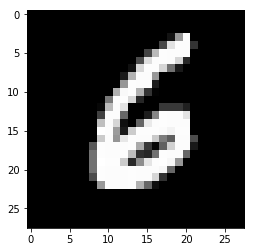

In [16]:
preview_tf_mnist(121)

We can use a simple neural network (one without hidden layer as shown below) for this task. The code below builds such a neural network with TensorFlow. 

<img src="./imgs/nn.png" width="500px">

In [17]:
# create new tensorflow session
sess = tf.InteractiveSession()

# create placeholders for inputs and outputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784, 10])) # initialize weight as zero
b = tf.Variable(tf.zeros([10])) # initialize bias as zero

# initialize variables into session
sess.run(tf.global_variables_initializer())

# tf.matmul: matrix multiplication
y = tf.matmul(x, W) + b

In [18]:
# define cost function 
# tf.reduce_mean: Computes the mean of elements across dimensions of a tensor.
# tf.nn.softmax_cross_entropy_with_logits: Computes softmax cross entropy between `logits` and `labels` 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

In [19]:
# Gradient Descent optimizer
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cross_entropy)

In [20]:
# train the neural net for 1000 iterations
for i in range(1000):
    batch = mnist.train.next_batch(100) # mini-batch
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

In [21]:
# evaluate the performance
correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

('Accuracy:', 0.9181)


The result is not too bad. We obtain 92% accuracy for a 10 class classification problem in less than 15 lines of code.

### TensorFlow Takeaways

- Tensorflow is a programming framework used in deep learning  
- The two main object classes in tensorflow are Tensors and Operators. When you code in tensorflow you have to take the following steps:  
    1. Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)  
    2. Create a session  
    3. Initialize the session  
    4. Run the session to execute the graph  
- You can execute the graph multiple times
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object  

## 2 | Keras 

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

Use Keras if you need a deep learning library that:
  - Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
  - Supports both convolutional networks and recurrent networks, as well as combinations of the two.
  - Runs seamlessly on CPU and GPU.

Let's build the same neural network with Keras and see how it compares with TensorFlow. 

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


In order to define the model architecture, the first step is to declare a sequential model format. `Sequential` model type is simply a linear stack of neural network layers. Then, we can declare the input layer. Here, `Dense` is one of Keras' core layers. It is the regular densely-connected neural network layer. We can simply add more layers to our model like we're building legos using `model.add()`. Finally, we can define the loss function and the optimizer, and then we'll be ready to train it.

We can view the model architecture using `model.summary()`. 

Note that in actual R&D work, researchers will spend a considerable amount of time studying model architectures. But as we're just starting out, we can just replicate proven architectures from academic papers or use existing examples. Here's a list of [example implementations in Keras](https://github.com/fchollet/keras/tree/master/examples).

In [23]:
model = Sequential() # declare a sequential model format 
model.add(Dense(10, input_dim=784, activation='softmax')) # declare the input layer
sgd = SGD(lr=0.5) # define optimizer
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) # configures the learning process
print(model.summary()) # check the model architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
# Trains the model for a fixed number of epochs
model.fit(mnist.train.images, mnist.train.labels, batch_size=100, epochs=5, 
          validation_data=(mnist.test.images, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 0s - loss: 0.4000 - acc: 0.8852 - val_loss: 0.2954 - val_acc: 0.9188
Epoch 2/5
55000/55000 [==============================] - 0s - loss: 0.3112 - acc: 0.9123 - val_loss: 0.2875 - val_acc: 0.9171
Epoch 3/5
55000/55000 [==============================] - 0s - loss: 0.2952 - acc: 0.9168 - val_loss: 0.2968 - val_acc: 0.9155
Epoch 4/5
55000/55000 [==============================] - 0s - loss: 0.2879 - acc: 0.9193 - val_loss: 0.2826 - val_acc: 0.9179
Epoch 5/5
55000/55000 [==============================] - 0s - loss: 0.2817 - acc: 0.9197 - val_loss: 0.2869 - val_acc: 0.9194


In [25]:
# evaluate the performance
score = model.evaluate(mnist.test.images, mnist.test.labels, verbose=0)
print('Accuracy:', score[1])

('Accuracy:', 0.9194)


As you can see, we get the same performance but with half amount of code. Building neural networks in Keras is just as easy as scikit-learn. In fact, keras provides an interface with scikit-learn, so that you can use neural networks just like any other ML algorithm. 

### EXERCISE 

Use Keras to build a more complicated neural network. For example, the neural network built with the code below has one hidden layers. Run the cells below to see whether the performance improves. Build your own neural network. What is the architecture of your new model and what is the performance? 

In [26]:
model = Sequential() # declare a sequential model format 
model.add(Dense(64, input_dim=784, activation='relu')) # declare the input layer
model.add(Dense(10, input_dim=64, activation='softmax')) # declare the hidden layer
sgd = SGD(lr=0.5) # define optimizer
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) # configures the learning process
print(model.summary()) # check the model architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
model.fit(mnist.train.images, mnist.train.labels, batch_size=100, epochs=5, 
          validation_data=(mnist.test.images, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 1s - loss: 0.3092 - acc: 0.9059 - val_loss: 0.1562 - val_acc: 0.9533
Epoch 2/5
55000/55000 [==============================] - 1s - loss: 0.1417 - acc: 0.9574 - val_loss: 0.1409 - val_acc: 0.9568
Epoch 3/5
55000/55000 [==============================] - 1s - loss: 0.1023 - acc: 0.9693 - val_loss: 0.1017 - val_acc: 0.9673
Epoch 4/5
55000/55000 [==============================] - 1s - loss: 0.0827 - acc: 0.9748 - val_loss: 0.0952 - val_acc: 0.9702
Epoch 5/5
55000/55000 [==============================] - 0s - loss: 0.0688 - acc: 0.9783 - val_loss: 0.0894 - val_acc: 0.9709


In [28]:
score = model.evaluate(mnist.test.images, mnist.test.labels, verbose=0)
print('Accuracy:', score[1])

('Accuracy:', 0.97089999999999999)
